# IDMB Movie Review Classification #

* Morgan Didjurgis
* Flex 40 weeks
* Instructor: Abhineet Kulkarni

## Overview ##

This project builds a binary text classification model to identify whether IMDB reviews are positive or negative.

### Business Understanding ###

Sentiment analysis can help businesses find positive and negative customer feedback on their products.  The ability to classify a movie review as positive or negative can be used in a similar way, allowing for overall descriptive analysis of audience reception as well as further analysis of what drove either positive or negative reviews.  

IMDB star ratings are often inflated, so it can be challenging to rely on these numbers alone to classify reviews. Furthermore, this model could be applied to reviews where there is no star rating available.

### Data Understanding ###

The data set used to build this model came from __[Kaggle](https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis)__ and has ~40k reviews labeled either positive or negative. The classes are evenly balanced and there is no other metadata provided with the reviews and labels. 

### Approach ###

For text classification, there are many options when it comes to how to preprocess the data and which models/hyperparameters to use.  In order to test various preprocessing methods, I built a Preprocess class that allowed me to conduct a grid search through different combinations of preprocessing and apply them to a few different models.  

Training was conducted with data vectorized in three different ways: Count, TFIDF, and Mean Word Embeddings 
and then results were compared.  Other preprocessing steps that were tried include whether to stem or lemmatize the words, max_df values, and chi squared feature selection.

I used the data to train Naive Bayes, Logistic Regression, Support Vector Machine, and XGBoost gradient boosting models.  Ultimately, Logistic Regression with TFIDF vectorization performed the best and I conducted a gridsearch to tune the hyperparameters for this model.

While more complex models exist for this task, such as using transfer learning on transformer based models like BERT, the Logistic Regression model achieved an accuracy of 90%. For our purposes, this is a good score and using logistic regression allows us to more easily interpret the model to understand which words/features are most important to a positive or negative classification.

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize, FreqDist, regexp_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.collocations import BigramAssocMeasures
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectPercentile, mutual_info_classif, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from gensim.models import word2vec
from spellchecker import SpellChecker
from collections import Counter
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import json
import requests
import xgboost as xgb
import itertools
import string
import re
%matplotlib inline

In [33]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/morgandj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/morgandj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Exploration #

In [34]:
file='movie.csv'
df=pd.read_csv(file)

In [35]:
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [36]:
df['label'].value_counts()

0    20019
1    19981
Name: label, dtype: int64

The classes are balanced, which will help when building a classification model.

In [406]:
text=df['text'].str.lower()
labels=df['label']
X_train, X_test, y_train, y_test = train_test_split(text,labels,test_size=.2,random_state=20)

In [38]:
X_train.head()

36862    ok, here it is: "nazi mountaineer befriends th...
11768    romance is in the air and love is in bloom in ...
36393    this film is described as a action/comedy. the...
12031    i love the satan pit!!! david tennant is such ...
27211    i could never stand watching happy days after ...
Name: text, dtype: object

### Tokenize ###

In [407]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
stopwords_list=stopwords.words('english')
tokenizer=RegexpTokenizer(pattern)
tokenized_train=X_train.apply(tokenizer.tokenize)

In [408]:
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [409]:
ns_tk_train=tokenized_train.apply(remove_stopwords)

In [43]:
tokenized_train.head()

36862    [ok, here, it, is, nazi, mountaineer, befriend...
11768    [romance, is, in, the, air, and, love, is, in,...
36393    [this, film, is, described, as, a, action, com...
12031    [i, love, the, satan, pit, david, tennant, is,...
27211    [i, could, never, stand, watching, happy, days...
Name: text, dtype: object

In [44]:
ns_tk_train.head()

36862    [ok, nazi, mountaineer, befriends, dalai, lama...
11768    [romance, air, love, bloom, victorian, era, en...
36393    [film, described, action, comedy, first, minut...
12031    [love, satan, pit, david, tennant, great, acto...
27211    [could, never, stand, watching, happy, days, c...
Name: text, dtype: object

In [410]:
new_df=pd.concat([tokenized_train,ns_tk_train,y_train],axis=1)
new_df.columns=['token','no-stop','label']

In [411]:
pos_reviews=new_df[new_df['label']==1]
neg_reviews=new_df[new_df['label']==0]

In [412]:
#Get Freq distributions for tokens w/ and w/o stopwords and compare top words
pos_freq = FreqDist(pos_reviews['token'].explode()).most_common(10)
pos_ns_freq = FreqDist(pos_reviews['no-stop'].explode()).most_common(10)
neg_freq = FreqDist(neg_reviews['token'].explode()).most_common(10)
neg_ns_freq = FreqDist(neg_reviews['no-stop'].explode()).most_common(10)
freqs=[pos_freq,pos_ns_freq,neg_freq,neg_ns_freq]

In [48]:
#total number of words in all reviews after stop words removed
fd=FreqDist(new_df['no-stop'].explode())
len(fd)

90425

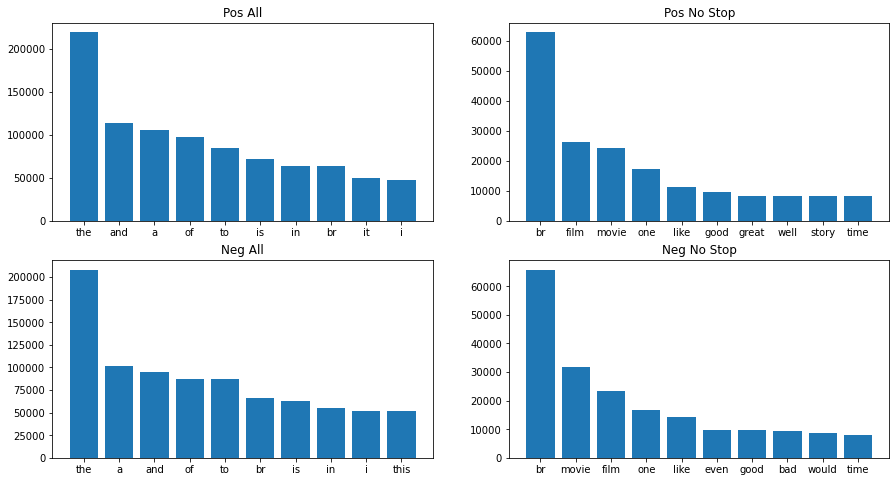

In [413]:
#Plot distributions for comparison
fig,axes=plt.subplots(2,2,figsize=(15,8))
titles=['Pos All','Pos No Stop','Neg All','Neg No Stop']

for count,ax in enumerate(axes.flatten()):
    x=[tup[0] for tup in freqs[count]]
    y=[tup[1] for tup in freqs[count]]
    ax.bar(x,y)
    ax.set_title(titles[count])


Need to investigate the token 'br'. Probably denotes a line break and shouldn't be included.

It appears that removing stop words helps differentiate between pos and neg reviews.  However, many of the top ten words are the same so we will need to train the model on a larger selection.  After removing stop words there are over 90k words in all the ratings so we will have to find a balance between reducing dimensionality and including enough training info.

In [414]:
new_df['contains_br']=new_df['no-stop'].apply(lambda x: 1 if 'br' in x else 0)
contains_br=new_df[new_df['contains_br']==1]
contains_br.head()

,token,no-stop,label,contains_br
11768,"[romance, is, in, the, air, and, love, is, in,...","[romance, air, love, bloom, victorian, era, en...",1,1
36393,"[this, film, is, described, as, a, action, com...","[film, described, action, comedy, first, minut...",0,1
14337,"[well, eyeboy, i, must, say, that, it, pleases...","[well, eyeboy, must, say, pleases, end, someon...",0,1
16003,"[what, do, you, mean, son, of, actor, not, an,...","[mean, son, actor, actor, become, actor, daddy...",1,1
2468,"[wwe's, last, ppv, of, proved, to, be, a, hit,...","[wwe's, last, ppv, proved, hit, fans, one, rea...",1,1


Its clear that br is indicating line breaks. We'll remove this from all the token lists.

In [415]:
tokens_train=ns_tk_train.apply(lambda tok_list: [tok for tok in tok_list if tok!='br'])

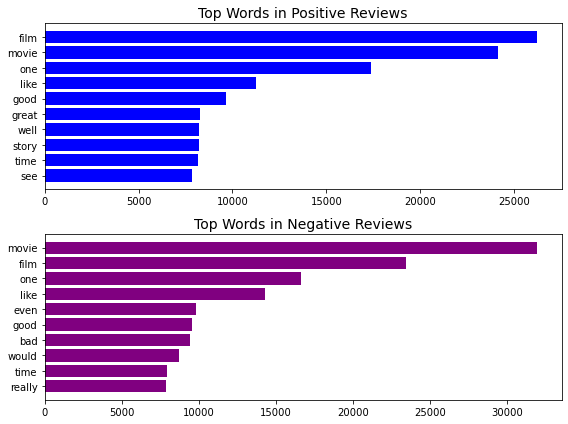

In [427]:
#redo top freq charts
tok_df=pd.concat([tokens_train,y_train],axis=1)
tok_df.columns=['token','label']
pos=tok_df[tok_df['label']==1]
neg=tok_df[tok_df['label']==0]
pos_fd=FreqDist(pos['token'].explode()).most_common(10)
neg_fd=FreqDist(neg['token'].explode()).most_common(10)
pos_fd.sort(key=lambda x: x[1])
neg_fd.sort(key=lambda x: x[1])

fig,axes=plt.subplots(2,figsize=(8,6))

pos_x=[tup[0] for tup in pos_fd]
pos_y=[tup[1] for tup in pos_fd]
neg_x=[tup[0] for tup in neg_fd]
neg_y=[tup[1] for tup in neg_fd]



axes[0].barh(pos_x,pos_y,color='blue')
axes[0].set_title('Top Words in Positive Reviews',fontsize=14)
axes[1].barh(neg_x,neg_y,color='purple')
axes[1].set_title('Top Words in Negative Reviews',fontsize=14)
plt.tight_layout()

There is not a huge difference between the top 20 words in the corpus. We'll use more for the model, but this could also indicate the importance of using bigrams to indicate how words are used together or using sequences.

### Define stopwords for model ###

Below we define the stopwords list, using NLTK's english stopword list as the base.  I added 'br' which appears often in the text to denote line breaks and removed some words which could be useful for sentiment analysis. Some of the data exploration that led to these choices is outlined below.

I also stemmed and lemmatized the stopwords list to be used with data that has been either stemmed or lemmatized.

In [255]:
stopwords_list=stopwords.words('english')
stopwords_list.append('br')
remove=['up','down','didn',"didn't",'wasn',"wasn't",'wouldn',"wouldn't"]
for word in remove:
    stopwords_list.remove(word)
    
stemmer=SnowballStemmer('english')
stopwords_stemmed=[]

for w in stopwords_list:
    stopwords_stemmed.append(stemmer.stem(w))
    
wnl=WordNetLemmatizer()
stopwords_lemmatized=[]

for w in stopwords_list:
    stopwords_lemmatized.append(wnl.lemmatize(w))

# Preprocess

Build a preprocessing pipeline that allows parameters to select different types of preprocessing steps. This will allow us to perform grid searches across different nlp preprocessing steps to see what gives our models the best output.  

Of note, this class is built only for use when training the data and will not allow 'unseen' data to be transformed on an already fit model.  Once the model is chosen, we will build a standard sklearn pipeline using the selected preprocessing steps and parameters.

I chose to build this pipeline for training because it allowed me to try different combinations in a more orderly manner and keep better track of the results.

In [53]:
def correct_spelling(tokens):
    spell=SpellChecker()
    fixed=[spell.correction(t) if len(spell.unknown([t]))>0 else t for t in tokens]
    return fixed

In [54]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(w2v))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [55]:
class DummyTransformer(BaseEstimator, TransformerMixin):
    """
    Dummy class that allows us to modify only the methods that interest us,
    avoiding redudancy.
    """
    def __init__(self):
        return None

    def fit(self, X=None, y=None):
        return self

    def transform(self, X=None):
        return self

In [56]:
class Preprocess(DummyTransformer):
    
    def __init__(self,
                 stopwords_list=stopwords_list,
                 stopwords_stemmed=stopwords_stemmed,
                 stopwords_lemmatized=stopwords_lemmatized,
                 vector='count', 
                 stemming=None,
                 spell_check=False,
                n_grams=(1,1),
                max_df=1.0,
                 max_feat=None,
                chi_percent=None,
                y=None):
        #defines how the text will be preprocessed
        
        self.stopwords_list=stopwords_list
        self.stopwords_stemmed=stopwords_stemmed
        self.stopwords_lemmatized=stopwords_lemmatized
        self.vector = vector 
        #can be 'count','tfidf',or 'embedding'
        self.stemming=stemming
        #can be 'None','stem','lemmatize'
        self.spell_check=spell_check
        #True or False
        self.n_grams=n_grams
        #n_gram to pass to tokenizer like (1,1) or (1,2)
        self.max_df=max_df
        #positive float less than or equal to 1.0, to pass to vectorizer
        self.max_features=max_feat
        self.chi_percent=chi_percent
        self.y=y
        #positive integer less than 100, percent features to keep if filtering with chi2
        #None if no filtering
        #self.glove_file_=glove_file
        #None if using count or tfidf, glove file for word embeddings
         
            
    def tokenize(self,text):
        pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
        tokenizer=RegexpTokenizer(pattern)
        tokens=tokenizer.tokenize(text)
        
        if self.spell_check==True:
            tokens=correct_spelling(tokens)
        
        if self.stemming=='lemmatize':
            
            wnl=WordNetLemmatizer()
            
            stems = []
            
            for item in tokens:
                stems.append(wnl.lemmatize(item))
                
        elif self.stemming=='stem':
            stems=[]
            stemmer=SnowballStemmer('english')
            
            for item in tokens:
                stems.append(stemmer.stem(item))
        
        else:
            stems=tokens
        return stems
    
    def filter_words_by_count(self,X,tokenized):
        
        sw=[self.stopwords_list,self.stopwords_stemmed,self.stopwords_lemmatized]
        if self.stemming=='None':
            idx=0
        elif self.stemming=='stem':
            idx=1
        else:
            idx=2
            
        vectorizer=CountVectorizer(stop_words=sw[idx],
                                   max_df=self.max_df,
                                   min_df=5)
        vectorizer.fit(X)

        #filter out words
        words_to_keep=vectorizer.vocabulary_.keys()
        filtered_data=tokenized.apply(lambda tok: [w for w in tok if w in words_to_keep])

        return filtered_data
    
    def build_glove(self,tokens):
        total_vocab=set([word for review in tokens for word in review])
        glove = {}
        #count=0
        #words=[]
        with open('glove.6B.300d.txt', 'rb') as f:
            for line in f:
                parts = line.split()
                word = parts[0].decode('utf-8')
                if word in total_vocab:
                    vector = np.array(parts[1:], dtype=np.float32)
                    glove[word] = vector
                    #count+=1
                    #words.append(word)
        return glove

    def transform(self, X):
        
        #tokenize according to inputs
        sw=[self.stopwords_list,self.stopwords_stemmed,self.stopwords_lemmatized]
        if self.stemming=='None':
            idx=0
        elif self.stemming=='stem':
            idx=1
        else:
            idx=2
        
        if self.vector=='count':
            
            vectorizer=CountVectorizer(stop_words=sw[idx],
                                       max_features=self.max_features,
                                       tokenizer=self.tokenize,
                                       ngram_range=self.n_grams,
                                       min_df=5,
                                       max_df=self.max_df
                                      )
            tokens=vectorizer.fit_transform(X).toarray()
        
        elif self.vector=='tfidf':
            
            vectorizer=TfidfVectorizer(stop_words=sw[idx],
                                       max_features=self.max_features,
                                       tokenizer=self.tokenize,
                                       ngram_range=self.n_grams,
                                       min_df=5,
                                       max_df=self.max_df
                                      )
            tokens=vectorizer.fit_transform(X).toarray()
            
        elif self.vector=='embedding':
            tokenized=X.apply(self.tokenize)
            filtered=self.filter_words_by_count(X,tokenized)
            glove=self.build_glove(filtered)
            w2v=W2vVectorizer(glove)
            tokens=w2v.transform(filtered)
            
        if (self.chi_percent != None) and (self.vector != 'embedding'):
            
            selector=SelectPercentile(chi2,percentile=self.chi_percent)
            selected=selector.fit_transform(tokens,self.y)
            tokens=selected
        #print('finished')
        return tokens


In [57]:
def preprocess_grid(X_train,y_train,vector_type,params_lists):
    combos=list(itertools.product(*params_lists))
    print(len(combos))
    tokenized=[]
    count=0
    for c in combos:
        pp=Preprocess(stopwords_list=stopwords_list,
                      vector=vector_type, 
                     stemming=c[0],
                     spell_check=c[1],
                    n_grams=c[2],
                    max_df=c[3],
                    chi_percent=c[4],
                      max_feat=20000,
                    y=y_train)
        tokens=pp.transform(X_train)
        tokenized.append((c,tokens))
        count+=1
        #print(count)
    return tokenized

In [58]:
def pipeline_nlp(estimator,vector_type,X_train,y_train,params_lists):
    #returns results from cross validation
    
    tokenized = preprocess_grid(X_train,y_train,vector_type,params_lists)
    results=[]

    count=0

    for features, xtrain in tokenized:
        result=cross_val_score(estimator,xtrain,y_train,cv=3)
        results.append((features,result.mean()))
        count+=1
        #print(count)
    
    return pd.DataFrame(results)

# Naive Bayes #

## Count Vectorization ##

Start by exploring different preprocessing steps with a baseline Naive Bayes model.

In [59]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

lists=[[None],
      [False],
      [(1,1),(1,2)],
      [.3,.5],
      [None,10]]
combos=list(itertools.product(*lists))
print(len(combos))
tokenized=[]
count=0
for c in combos:
    pp=Preprocess(vector='count', 
                 stemming=c[0],
                 spell_check=c[1],
                n_grams=c[2],
                max_df=c[3],
                chi_percent=c[4],
                  max_feat=20000,
                y=y_train)
    tokens=pp.transform(X_train)
    tokenized.append((c,tokens))
    count+=1
    print(count)

8
1
2
3
4
5
6
7
8


In [60]:
results=[]
nb=GaussianNB()

for features, xtrain in tokenized:
    result=cross_val_score(nb,xtrain,y_train,cv=3)
    results.append((features,result.mean()))
    
results

[((None, False, (1, 1), 0.3, None), 0.6769684407656654),
 ((None, False, (1, 1), 0.3, 10), 0.685250152710339),
 ((None, False, (1, 1), 0.5, None), 0.6771559583447061),
 ((None, False, (1, 1), 0.5, 10), 0.6871564017374691),
 ((None, False, (1, 2), 0.3, None), 0.8170622310796084),
 ((None, False, (1, 2), 0.3, 10), 0.8382186285864766),
 ((None, False, (1, 2), 0.5, None), 0.8155622047086671),
 ((None, False, (1, 2), 0.5, 10), 0.838781119798238)]

In [61]:
df_results=pd.DataFrame(results)
df_results

,0,1
0,"(None, False, (1, 1), 0.3, None)",0.676968
1,"(None, False, (1, 1), 0.3, 10)",0.685250
2,"(None, False, (1, 1), 0.5, None)",0.677156
3,"(None, False, (1, 1), 0.5, 10)",0.687156
4,"(None, False, (1, 2), 0.3, None)",0.817062
5,"(None, False, (1, 2), 0.3, 10)",0.838219
6,"(None, False, (1, 2), 0.5, None)",0.815562
7,"(None, False, (1, 2), 0.5, 10)",0.838781


Count vectors that include bigrams clearly outperform those with only single words. Chi2 feature selection also seems to increase accuracy. Now test for stemmed words.

In [62]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[['stem'],
      [False],
      [(1,2)],
      [.3,.5],
      [10,20]]

tokenized = preprocess_grid(X_train,y_train,'count',params_lists)

results=[]
nb=GaussianNB()
count=0

for features, xtrain in tokenized:
    result=cross_val_score(nb,xtrain,y_train,cv=3)
    results.append((features,result.mean()))
    count+=1
    print(count)
    
results

4
1
2
3
4


[(('stem', False, (1, 2), 0.3, 10), 0.8414062721518764),
 (('stem', False, (1, 2), 0.3, 20), 0.8241562398906143),
 (('stem', False, (1, 2), 0.5, 10), 0.8418749576976526),
 (('stem', False, (1, 2), 0.5, 20), 0.8214688092234694)]

In [63]:
count_results=pd.concat([df_results,pd.DataFrame(results)])

In [64]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[['lemmatize'],
      [False],
      [(1,2)],
      [.3,.5,.6],
      [10]]

nb=GaussianNB()

result_df=pipeline_nlp(nb,'count',X_train,y_train,params_lists)

3


In [65]:
count_results=pd.concat([count_results,result_df]).sort_values(by=1,ascending=False)

In [66]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[['stem'],
      [False],
      [(1,2)],
      [.3,.5,.6],
      [7,10,15]]

nb=GaussianNB()

result_df=pipeline_nlp(nb,'count',X_train,y_train,params_lists)
print(result_df)
count_results=pd.concat([count_results,result_df]).sort_values(by=1,ascending=False)

9
                                0         1
0   (stem, False, (1, 2), 0.3, 7)  0.829344
1  (stem, False, (1, 2), 0.3, 10)  0.841406
2  (stem, False, (1, 2), 0.3, 15)  0.825250
3   (stem, False, (1, 2), 0.5, 7)  0.829031
4  (stem, False, (1, 2), 0.5, 10)  0.841875
5  (stem, False, (1, 2), 0.5, 15)  0.823156
6   (stem, False, (1, 2), 0.6, 7)  0.828937
7  (stem, False, (1, 2), 0.6, 10)  0.843437
8  (stem, False, (1, 2), 0.6, 15)  0.825219


In [67]:
count_results

,0,1
7,"(stem, False, (1, 2), 0.6, 10)",0.843437
2,"(stem, False, (1, 2), 0.5, 10)",0.841875
4,"(stem, False, (1, 2), 0.5, 10)",0.841875
0,"(stem, False, (1, 2), 0.3, 10)",0.841406
1,"(stem, False, (1, 2), 0.3, 10)",0.841406
7,"(None, False, (1, 2), 0.5, 10)",0.838781
0,"(lemmatize, False, (1, 2), 0.3, 10)",0.838500
5,"(None, False, (1, 2), 0.3, 10)",0.838219
2,"(lemmatize, False, (1, 2), 0.6, 10)",0.836969
1,"(lemmatize, False, (1, 2), 0.5, 10)",0.835562


In [68]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None,'stem'],
      [False],
      [(1,2)],
      [.2,.7],
      [10,12]]

nb=GaussianNB()

result_df=pipeline_nlp(nb,'count',X_train,y_train,params_lists)
print(result_df)
count_results=pd.concat([count_results,result_df]).sort_values(by=1,ascending=False)

8
                                0         1
0  (None, False, (1, 2), 0.2, 10)  0.839062
1  (None, False, (1, 2), 0.2, 12)  0.848625
2  (None, False, (1, 2), 0.7, 10)  0.840000
3  (None, False, (1, 2), 0.7, 12)  0.849000
4  (stem, False, (1, 2), 0.2, 10)  0.836750
5  (stem, False, (1, 2), 0.2, 12)  0.820313
6  (stem, False, (1, 2), 0.7, 10)  0.843250
7  (stem, False, (1, 2), 0.7, 12)  0.830719


In [69]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[['stem'],
      [False],
      [(1,2)],
      [.2,.7],
      [10]]

nb=GaussianNB()

result_df=pipeline_nlp(nb,'count',X_train,y_train,params_lists)
print(result_df)
count_results=pd.concat([count_results,result_df]).sort_values(by=1,ascending=False)

2
                                0        1
0  (stem, False, (1, 2), 0.2, 10)  0.83675
1  (stem, False, (1, 2), 0.7, 10)  0.84325


The best score for NB count vectorization was 84.3%

## TFIDF Vectorization

In [70]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.4,.5,.7],
      [10,20,30]]

nb=GaussianNB()

result_df=pipeline_nlp(nb,'tfidf',X_train,y_train,params_lists)
idf_results=result_df
idf_results

9


,0,1
0,"(None, False, (1, 2), 0.4, 10)",0.835781
1,"(None, False, (1, 2), 0.4, 20)",0.860312
2,"(None, False, (1, 2), 0.4, 30)",0.857812
3,"(None, False, (1, 2), 0.5, 10)",0.836219
4,"(None, False, (1, 2), 0.5, 20)",0.860656
5,"(None, False, (1, 2), 0.5, 30)",0.858250
6,"(None, False, (1, 2), 0.7, 10)",0.837500
7,"(None, False, (1, 2), 0.7, 20)",0.860156
8,"(None, False, (1, 2), 0.7, 30)",0.858000


In [71]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.2,.7],
      [10,50]]

nb=GaussianNB()

result_df=pipeline_nlp(nb,'tfidf',X_train,y_train,params_lists)
idf_results=pd.concat([idf_results,result_df]).sort_values(by=1,ascending=False)
idf_results

4


,0,1
4,"(None, False, (1, 2), 0.5, 20)",0.860656
1,"(None, False, (1, 2), 0.4, 20)",0.860312
7,"(None, False, (1, 2), 0.7, 20)",0.860156
5,"(None, False, (1, 2), 0.5, 30)",0.858250
8,"(None, False, (1, 2), 0.7, 30)",0.858000
2,"(None, False, (1, 2), 0.4, 30)",0.857812
3,"(None, False, (1, 2), 0.7, 50)",0.849125
1,"(None, False, (1, 2), 0.2, 50)",0.848969
6,"(None, False, (1, 2), 0.7, 10)",0.837500
2,"(None, False, (1, 2), 0.7, 10)",0.837500


In [72]:
idf_results.to_csv('nb_tfidf_results.csv')

The best score for NB TFIDF Vectorization was 86.1%

## Mean Word Embeddings

In [73]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None,'stem','lemmatize'],
      [False],
      [(1,1)],
      [.2,.5,.7],
      [None]]

nb=GaussianNB()

result_df=pipeline_nlp(nb,'embedding',X_train,y_train,params_lists)
nb_mwe_results=result_df.sort_values(by=1,ascending=False)
nb_mwe_results

9


,0,1
1,"(None, False, (1, 1), 0.5, None)",0.738969
2,"(None, False, (1, 1), 0.7, None)",0.738562
7,"(lemmatize, False, (1, 1), 0.5, None)",0.738031
8,"(lemmatize, False, (1, 1), 0.7, None)",0.736875
0,"(None, False, (1, 1), 0.2, None)",0.730437
6,"(lemmatize, False, (1, 1), 0.2, None)",0.729125
4,"(stem, False, (1, 1), 0.5, None)",0.710031
5,"(stem, False, (1, 1), 0.7, None)",0.707156
3,"(stem, False, (1, 1), 0.2, None)",0.691469


In [74]:
nb_mwe_results.to_csv('nb_mwe_results.csv')

NB with mean word embeddings performed much worse, with the highest accuracy at 73.9%.

# Logistic Regression

## Count Vectorization

Try Logreg with count/tfidf vectors, stemming, n-grams

In [75]:
vectorizer=CountVectorizer(stop_words=stopwords_list,max_features=5000)
tokens_train=vectorizer.fit_transform(X_train).toarray()

logreg=LogisticRegression(max_iter=500)

logreg.fit(tokens_train,y_train)
results=cross_val_score(logreg,tokens_train,y_train)
print(results)
results.mean()

[0.85390625 0.85984375 0.86046875 0.856875   0.86296875]


0.8588125

In [76]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None,'stem'],
      [False],
      [(1,1),(1,2)],
      [.2,.5,.7],
      [10]]

logreg=LogisticRegression(max_iter=500)

result_df=pipeline_nlp(logreg,'count',X_train,y_train,params_lists)
logreg_results=result_df.sort_values(by=1,ascending=False)
logreg_results

12


,0,1
5,"(None, False, (1, 2), 0.7, 10)",0.886531
4,"(None, False, (1, 2), 0.5, 10)",0.886250
10,"(stem, False, (1, 2), 0.5, 10)",0.885500
3,"(None, False, (1, 2), 0.2, 10)",0.885344
11,"(stem, False, (1, 2), 0.7, 10)",0.885281
9,"(stem, False, (1, 2), 0.2, 10)",0.883656
1,"(None, False, (1, 1), 0.5, 10)",0.883656
2,"(None, False, (1, 1), 0.7, 10)",0.883594
0,"(None, False, (1, 1), 0.2, 10)",0.881625
7,"(stem, False, (1, 1), 0.5, 10)",0.880031


In [77]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[['stem','lemmatize'],
      [False],
      [(1,2)],
      [.7],
      [8,10,12]]

logreg=LogisticRegression(max_iter=500)

result_df=pipeline_nlp(logreg,'count',X_train,y_train,params_lists)
logreg_results=pd.concat([logreg_results,result_df]).sort_values(by=1,ascending=False)
logreg_results

6


,0,1
5,"(None, False, (1, 2), 0.7, 10)",0.886531
4,"(None, False, (1, 2), 0.5, 10)",0.886250
0,"(stem, False, (1, 2), 0.7, 8)",0.886031
2,"(stem, False, (1, 2), 0.7, 12)",0.885875
10,"(stem, False, (1, 2), 0.5, 10)",0.885500
3,"(None, False, (1, 2), 0.2, 10)",0.885344
11,"(stem, False, (1, 2), 0.7, 10)",0.885281
1,"(stem, False, (1, 2), 0.7, 10)",0.885281
5,"(lemmatize, False, (1, 2), 0.7, 12)",0.885063
4,"(lemmatize, False, (1, 2), 0.7, 10)",0.885031


In [78]:
logreg_results.to_csv('lr_count_results.csv')

The best score for LogReg with count vectorization is 88.7%

## TFIDF ##

In [79]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None,'stem','lemmatize'],
      [False],
      [(1,2)],
      [.3,.5,.7],
      [10]]

logreg=LogisticRegression(max_iter=500)

result_df=pipeline_nlp(logreg,'tfidf',X_train,y_train,params_lists)
lr_tfidf_results=result_df.sort_values(by=1,ascending=False)
lr_tfidf_results

9


,0,1
1,"(None, False, (1, 2), 0.5, 10)",0.881656
2,"(None, False, (1, 2), 0.7, 10)",0.881187
0,"(None, False, (1, 2), 0.3, 10)",0.881094
4,"(stem, False, (1, 2), 0.5, 10)",0.880312
5,"(stem, False, (1, 2), 0.7, 10)",0.880219
3,"(stem, False, (1, 2), 0.3, 10)",0.879719
7,"(lemmatize, False, (1, 2), 0.5, 10)",0.879250
8,"(lemmatize, False, (1, 2), 0.7, 10)",0.879031
6,"(lemmatize, False, (1, 2), 0.3, 10)",0.877625


In [80]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.4,.6],
      [70,80]]

logreg=LogisticRegression(max_iter=500)

result_df=pipeline_nlp(logreg,'tfidf',X_train,y_train,params_lists)
lr_tfidf_results=pd.concat([lr_tfidf_results,result_df]).sort_values(by=1,ascending=False)
lr_tfidf_results

4


,0,1
1,"(None, False, (1, 2), 0.4, 80)",0.894625
3,"(None, False, (1, 2), 0.6, 80)",0.894594
2,"(None, False, (1, 2), 0.6, 70)",0.894531
0,"(None, False, (1, 2), 0.4, 70)",0.894406
1,"(None, False, (1, 2), 0.5, 10)",0.881656
2,"(None, False, (1, 2), 0.7, 10)",0.881187
0,"(None, False, (1, 2), 0.3, 10)",0.881094
4,"(stem, False, (1, 2), 0.5, 10)",0.880312
5,"(stem, False, (1, 2), 0.7, 10)",0.880219
3,"(stem, False, (1, 2), 0.3, 10)",0.879719


In [81]:
lr_tfidf_results.to_csv('lr_tfidf_results.csv')

The best score for LogReg with TFIDF Vectorization is 89.4%

In [82]:
#Grid search logreg hyperparameters w/best preprocessing

order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.6],
      [60]]

tokenized=preprocess_grid(X_train,y_train,'tfidf',params_lists)
X_train_pp=tokenized[0][1]

logreg=LogisticRegression()

params={
    'penalty': ['l1','l2','elasticnet'],
    'C': [.1,1,10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']
}

lr_gs=GridSearchCV(logreg,cv=3,param_grid=params,verbose=2,scoring='accuracy')
results=lr_gs.fit(X_train_pp,y_train)


1
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] C=0.1, penalty=l1, solver=newton-cg .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 pen

[CV] .............. C=0.1, penalty=l1, solver=newton-cg, total=  19.1s
[CV] C=0.1, penalty=l1, solver=newton-cg .............................
[CV] .............. C=0.1, penalty=l1, solver=newton-cg, total=  17.8s
[CV] C=0.1, penalty=l1, solver=newton-cg .............................
[CV] .............. C=0.1, penalty=l1, solver=newton-cg, total=  17.6s
[CV] C=0.1, penalty=l1, solver=lbfgs .................................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] .................. C=0.1, penalty=l1, solver=lbfgs, total=  16.2s
[CV] C=0.1, penalty=l1, solver=lbfgs .................................
[CV] .................. C=0.1, penalty=l1, solver=lbfgs, total=  15.7s
[CV] C=0.1, penalty=l1, solver=lbfgs .................................
[CV] .................. C=0.1, penalty=l1, solver=lbfgs, total=  14.5s
[CV] C=0.1, penalty=l1, solver=liblinear .............................
[CV] .............. C=0.1, penalty=l1, solver=liblinear, total=  21.8s
[CV] C=0.1, penalty=l1, solver=liblinear .............................
[CV] .............. C=0.1, penalty=l1, solver=liblinear, total=  22.2s
[CV] C=0.1, penalty=l1, solver=liblinear .............................
[CV] .............. C=0.1, penalty=l1, solver=liblinear, total=  19.8s
[CV] C=0.1, penalty=l1, solver=saga ..................................
[CV] ................... C=0.1, penalty=l1, solver=saga, total= 1.2min
[CV] C=0.1, penalty=l1, solver=saga ..................................
[CV] .

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-tes

[CV] ...... C=0.1, penalty=elasticnet, solver=newton-cg, total=  17.7s
[CV] C=0.1, penalty=elasticnet, solver=newton-cg .....................
[CV] ...... C=0.1, penalty=elasticnet, solver=newton-cg, total=  18.4s
[CV] C=0.1, penalty=elasticnet, solver=newton-cg .....................
[CV] ...... C=0.1, penalty=elasticnet, solver=newton-cg, total=  18.0s
[CV] C=0.1, penalty=elasticnet, solver=lbfgs .........................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] .......... C=0.1, penalty=elasticnet, solver=lbfgs, total=  15.1s
[CV] C=0.1, penalty=elasticnet, solver=lbfgs .........................
[CV] .......... C=0.1, penalty=elasticnet, solver=lbfgs, total=  16.6s
[CV] C=0.1, penalty=elasticnet, solver=lbfgs .........................
[CV] .......... C=0.1, penalty=elasticnet, solver=lbfgs, total=  16.4s
[CV] C=0.1, penalty=elasticnet, solver=liblinear .....................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] ...... C=0.1, penalty=elasticnet, solver=liblinear, total=  15.1s
[CV] C=0.1, penalty=elasticnet, solver=liblinear .....................
[CV] ...... C=0.1, penalty=elasticnet, solver=liblinear, total=  15.9s
[CV] C=0.1, penalty=elasticnet, solver=liblinear .....................
[CV] ...... C=0.1, penalty=elasticnet, solver=liblinear, total=  17.5s
[CV] C=0.1, penalty=elasticnet, solver=saga ..........................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] ........... C=0.1, penalty=elasticnet, solver=saga, total=  14.3s
[CV] C=0.1, penalty=elasticnet, solver=saga ..........................
[CV] ........... C=0.1, penalty=elasticnet, solver=saga, total=  15.8s
[CV] C=0.1, penalty=elasticnet, solver=saga ..........................
[CV] ........... C=0.1, penalty=elasticnet, solver=saga, total=  16.9s
[CV] C=1, penalty=l1, solver=newton-cg ...............................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] ................ C=1, penalty=l1, solver=newton-cg, total=  17.1s
[CV] C=1, penalty=l1, solver=newton-cg ...............................
[CV] ................ C=1, penalty=l1, solver=newton-cg, total=  15.9s
[CV] C=1, penalty=l1, solver=newton-cg ...............................
[CV] ................ C=1, penalty=l1, solver=newton-cg, total=  16.2s
[CV] C=1, penalty=l1, solver=lbfgs ...................................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] .................... C=1, penalty=l1, solver=lbfgs, total=  16.5s
[CV] C=1, penalty=l1, solver=lbfgs ...................................
[CV] .................... C=1, penalty=l1, solver=lbfgs, total=  17.1s
[CV] C=1, penalty=l1, solver=lbfgs ...................................
[CV] .................... C=1, penalty=l1, solver=lbfgs, total=  16.0s
[CV] C=1, penalty=l1, solver=liblinear ...............................
[CV] ................ C=1, penalty=l1, solver=liblinear, total=  21.1s
[CV] C=1, penalty=l1, solver=liblinear ...............................
[CV] ................ C=1, penalty=l1, solver=liblinear, total=  21.4s
[CV] C=1, penalty=l1, solver=liblinear ...............................
[CV] ................ C=1, penalty=l1, solver=liblinear, total=  22.3s
[CV] C=1, penalty=l1, solver=saga ....................................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] ..................... C=1, penalty=l1, solver=saga, total= 5.4min
[CV] C=1, penalty=l1, solver=saga ....................................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] ..................... C=1, penalty=l1, solver=saga, total= 5.5min
[CV] C=1, penalty=l1, solver=saga ....................................
[CV] ..................... C=1, penalty=l1, solver=saga, total= 5.1min
[CV] C=1, penalty=l2, solver=newton-cg ...............................
[CV] ................ C=1, penalty=l2, solver=newton-cg, total= 3.5min
[CV] C=1, penalty=l2, solver=newton-cg ...............................
[CV] ................ C=1, penalty=l2, solver=newton-cg, total= 3.5min
[CV] C=1, penalty=l2, solver=newton-cg ...............................
[CV] ................ C=1, penalty=l2, solver=newton-cg, total= 3.8min
[CV] C=1, penalty=l2, solver=lbfgs ...................................
[CV] .................... C=1, penalty=l2, solver=lbfgs, total=  55.3s
[CV] C=1, penalty=l2, solver=lbfgs ...................................
[CV] .................... C=1, penalty=l2, solver=lbfgs, total=  42.4s
[CV] C=1, penalty=l2, solver=lbfgs ...................................
[CV] .

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-tes

[CV] ........ C=1, penalty=elasticnet, solver=newton-cg, total=  17.6s
[CV] C=1, penalty=elasticnet, solver=newton-cg .......................
[CV] ........ C=1, penalty=elasticnet, solver=newton-cg, total=  16.2s
[CV] C=1, penalty=elasticnet, solver=newton-cg .......................
[CV] ........ C=1, penalty=elasticnet, solver=newton-cg, total=  16.8s
[CV] C=1, penalty=elasticnet, solver=lbfgs ...........................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] ............ C=1, penalty=elasticnet, solver=lbfgs, total=  16.4s
[CV] C=1, penalty=elasticnet, solver=lbfgs ...........................
[CV] ............ C=1, penalty=elasticnet, solver=lbfgs, total=  14.9s
[CV] C=1, penalty=elasticnet, solver=lbfgs ...........................
[CV] ............ C=1, penalty=elasticnet, solver=lbfgs, total=  16.4s
[CV] C=1, penalty=elasticnet, solver=liblinear .......................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] ........ C=1, penalty=elasticnet, solver=liblinear, total=  15.5s
[CV] C=1, penalty=elasticnet, solver=liblinear .......................
[CV] ........ C=1, penalty=elasticnet, solver=liblinear, total=  16.6s
[CV] C=1, penalty=elasticnet, solver=liblinear .......................
[CV] ........ C=1, penalty=elasticnet, solver=liblinear, total=  16.9s
[CV] C=1, penalty=elasticnet, solver=saga ............................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] ............. C=1, penalty=elasticnet, solver=saga, total=  17.0s
[CV] C=1, penalty=elasticnet, solver=saga ............................
[CV] ............. C=1, penalty=elasticnet, solver=saga, total=  16.2s
[CV] C=1, penalty=elasticnet, solver=saga ............................
[CV] ............. C=1, penalty=elasticnet, solver=saga, total=  15.8s
[CV] C=10, penalty=l1, solver=newton-cg ..............................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] ............... C=10, penalty=l1, solver=newton-cg, total=  15.8s
[CV] C=10, penalty=l1, solver=newton-cg ..............................
[CV] ............... C=10, penalty=l1, solver=newton-cg, total=  15.5s
[CV] C=10, penalty=l1, solver=newton-cg ..............................
[CV] ............... C=10, penalty=l1, solver=newton-cg, total=  15.1s
[CV] C=10, penalty=l1, solver=lbfgs ..................................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] ................... C=10, penalty=l1, solver=lbfgs, total=  13.6s
[CV] C=10, penalty=l1, solver=lbfgs ..................................
[CV] ................... C=10, penalty=l1, solver=lbfgs, total=  17.9s
[CV] C=10, penalty=l1, solver=lbfgs ..................................
[CV] ................... C=10, penalty=l1, solver=lbfgs, total=  16.2s
[CV] C=10, penalty=l1, solver=liblinear ..............................
[CV] ............... C=10, penalty=l1, solver=liblinear, total=  20.5s
[CV] C=10, penalty=l1, solver=liblinear ..............................
[CV] ............... C=10, penalty=l1, solver=liblinear, total=  23.6s
[CV] C=10, penalty=l1, solver=liblinear ..............................
[CV] ............... C=10, penalty=l1, solver=liblinear, total=  21.8s
[CV] C=10, penalty=l1, solver=saga ...................................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] .................... C=10, penalty=l1, solver=saga, total= 9.0min
[CV] C=10, penalty=l1, solver=saga ...................................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] .................... C=10, penalty=l1, solver=saga, total= 7.8min
[CV] C=10, penalty=l1, solver=saga ...................................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] .................... C=10, penalty=l1, solver=saga, total= 7.8min
[CV] C=10, penalty=l2, solver=newton-cg ..............................
[CV] ............... C=10, penalty=l2, solver=newton-cg, total= 5.5min
[CV] C=10, penalty=l2, solver=newton-cg ..............................
[CV] ............... C=10, penalty=l2, solver=newton-cg, total= 5.0min
[CV] C=10, penalty=l2, solver=newton-cg ..............................
[CV] ............... C=10, penalty=l2, solver=newton-cg, total= 5.4min
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ................... C=10, penalty=l2, solver=lbfgs, total= 1.0min
[CV] C=10, penalty=l2, solver=lbfgs ..................................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ................... C=10, penalty=l2, solver=lbfgs, total= 1.1min
[CV] C=10, penalty=l2, solver=lbfgs ..................................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ................... C=10, penalty=l2, solver=lbfgs, total= 1.2min
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] ............... C=10, penalty=l2, solver=liblinear, total=  24.4s
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] ............... C=10, penalty=l2, solver=liblinear, total=  25.5s
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] ............... C=10, penalty=l2, solver=liblinear, total=  24.1s
[CV] C=10, penalty=l2, solver=saga ...................................
[CV] .................... C=10, penalty=l2, solver=saga, total= 2.7min
[CV] C=10, penalty=l2, solver=saga ...................................
[CV] .................... C=10, penalty=l2, solver=saga, total= 2.8min
[CV] C=10, penalty=l2, solver=saga ...................................
[CV] .................... C=10, penalty=l2, solver=saga, total= 2.5min
[CV] C=10, penalty=elasticnet, solver=newton-cg ......................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-tes

[CV] ....... C=10, penalty=elasticnet, solver=newton-cg, total=  19.1s
[CV] C=10, penalty=elasticnet, solver=newton-cg ......................
[CV] ....... C=10, penalty=elasticnet, solver=newton-cg, total=  17.4s
[CV] C=10, penalty=elasticnet, solver=newton-cg ......................
[CV] ....... C=10, penalty=elasticnet, solver=newton-cg, total=  15.9s
[CV] C=10, penalty=elasticnet, solver=lbfgs ..........................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] ........... C=10, penalty=elasticnet, solver=lbfgs, total=  15.0s
[CV] C=10, penalty=elasticnet, solver=lbfgs ..........................
[CV] ........... C=10, penalty=elasticnet, solver=lbfgs, total=  15.4s
[CV] C=10, penalty=elasticnet, solver=lbfgs ..........................
[CV] ........... C=10, penalty=elasticnet, solver=lbfgs, total=  15.2s
[CV] C=10, penalty=elasticnet, solver=liblinear ......................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] ....... C=10, penalty=elasticnet, solver=liblinear, total=  15.1s
[CV] C=10, penalty=elasticnet, solver=liblinear ......................
[CV] ....... C=10, penalty=elasticnet, solver=liblinear, total=  15.3s
[CV] C=10, penalty=elasticnet, solver=liblinear ......................
[CV] ....... C=10, penalty=elasticnet, solver=liblinear, total=  17.1s
[CV] C=10, penalty=elasticnet, solver=saga ...........................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] ............ C=10, penalty=elasticnet, solver=saga, total=  15.8s
[CV] C=10, penalty=elasticnet, solver=saga ...........................
[CV] ............ C=10, penalty=elasticnet, solver=saga, total=  16.2s
[CV] C=10, penalty=elasticnet, solver=saga ...........................
[CV] ............ C=10, penalty=elasticnet, solver=saga, total=  16.4s


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 122.7min finished


In [83]:
print(results.best_params_)
print(results.best_score_)

{'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.8972811931569761


In [84]:
params={
    'penalty': ['l2'],
    'C': [5],
    'solver': ['saga'],
    'max_iter': [1000]
}

lr_gs1=GridSearchCV(logreg,cv=3,param_grid=params,verbose=0,scoring='accuracy')
results_1=lr_gs1.fit(X_train_pp,y_train)
print(results_1.best_params_)
print(results_1.best_score_)

{'C': 5, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
0.8990312117156615


In [85]:
params={
    'penalty': ['l2'],
    'C': [5],
    'solver': ['saga'],
    'max_iter': [2000]
}

lr_gs1=GridSearchCV(logreg,cv=3,param_grid=params,verbose=0,scoring='accuracy')
results_1=lr_gs1.fit(X_train_pp,y_train)
print(results_1.best_params_)
print(results_1.best_score_)

{'C': 5, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'saga'}
0.8990312117156615


In [94]:
params={
    'penalty': ['elasticnet'],
    'C': [5,10,15],
    'solver': ['saga'],
    'max_iter': [1000],
    'l1_ratio': [.3,.5]
}

lr_gs1=GridSearchCV(logreg,cv=3,param_grid=params,verbose=0,scoring='accuracy')
results_1=lr_gs1.fit(X_train_pp,y_train)
print(results_1.best_params_)
print(results_1.best_score_)

{'C': 5, 'l1_ratio': 0.3, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
0.8975937009703306


The best score for logreg with tfidf vectorization after tuning hyperparameters is 90.0%

### Try feature selection with PCA ###

In [86]:
X_train_pp.shape

(32000, 12000)

In [87]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.6],
      [60]]

tokenized=preprocess_grid(X_train,y_train,'tfidf',params_lists)
X_train_pp=tokenized[0][1]

1


In [88]:
pca=PCA()
transformed=pca.fit_transform(X_train_pp)

In [89]:
transformed.shape

(32000, 12000)

In [90]:
np.cumsum(pca.explained_variance_ratio_)[8000]

0.9481752655469716

In [91]:
X_train_pca=transformed[:,:8000]

In [92]:
X_train_pca.shape

(32000, 8000)

In [93]:
params={
    'penalty': ['l2'],
    'C': [5],
    'solver': ['liblinear','lbfgs','newton-cg'],
    'max_iter': [1000]
}

logreg=LogisticRegression()

lr_gs1=GridSearchCV(logreg,cv=3,param_grid=params,verbose=0,scoring='accuracy')
results_1=lr_gs1.fit(X_train_pca,y_train)
print(results_1.best_params_)
print(results_1.best_score_)

{'C': 5, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
0.8983124929652342


## Mean Word Embedding

In [95]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None,'stem'],
      [False],
      [(1,2)],
      [.6],
      [None]]

logreg=LogisticRegression(max_iter=500)

result_df=pipeline_nlp(logreg,'embedding',X_train,y_train,params_lists)
lr_mwe_results=result_df.sort_values(by=1,ascending=False)
lr_mwe_results

2


,0,1
0,"(None, False, (1, 2), 0.6, None)",0.836875
1,"(stem, False, (1, 2), 0.6, None)",0.804187


In [96]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,1)],
      [.3,.5,.8],
      [None]]

logreg=LogisticRegression(max_iter=500)

result_df=pipeline_nlp(logreg,'embedding',X_train,y_train,params_lists)
lr_mwe_results=pd.concat([lr_mwe_results,result_df]).sort_values(by=1,ascending=False)
lr_mwe_results

3


,0,1
1,"(None, False, (1, 1), 0.5, None)",0.837000
0,"(None, False, (1, 2), 0.6, None)",0.836875
2,"(None, False, (1, 1), 0.8, None)",0.836250
0,"(None, False, (1, 1), 0.3, None)",0.835219
1,"(stem, False, (1, 2), 0.6, None)",0.804187


In [97]:
lr_mwe_results.to_csv('lr_mwe_results.csv')

The best score for a logreg model with mean word embeddings is 83.7%

# Support Vector Machine

In [98]:
#try relatively well-performing preprocessing steps with LinearSVC
#use LinearSVC due to sparse nature of the data

order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.5],
      [10]]

tokenized=preprocess_grid(X_train,y_train,'count',params_lists)
X_train_pp=tokenized[0][1]
features=tokenized[0][0]

svm=LinearSVC(max_iter=2000)

trainX,valX,trainy,testy=train_test_split(X_train_pp,y_train)

svm.fit(trainX,trainy)
y_hat=svm.predict(valX)
accuracy_score(testy,y_hat)



1


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.883125

In [99]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.6],
      [60]]

tokenized=preprocess_grid(X_train,y_train,'count',params_lists)
X_train_pp=tokenized[0][1]
features=tokenized[0][0]

svm=LinearSVC(max_iter=2000)

trainX,valX,trainy,testy=train_test_split(X_train_pp,y_train)

svm.fit(trainX,trainy)
y_hat=svm.predict(valX)
accuracy_score(testy,y_hat)


1


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.864625

Support vector machine performs well, but does not appear to perform as well as logistic regression.

# XGBoost

In [390]:
xgb_clf=xgb.XGBClassifier(objective='binary:logistic',
                         n_estimators=1000,
                         learning_rate=.01)

order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.5],
      [20]]

tokenized = preprocess_grid(X_train,y_train,'count',params_lists)


1


In [391]:
X_train_pp=tokenized[0][1]
features=tokenized[0][0]

xg_trainX, xg_testX, xg_trainy, xg_testy = train_test_split(X_train_pp, y_train, 
                                                           random_state=42,
                                                           stratify=y_train)
train_set=[(xg_trainX, xg_trainy)]
eval_set=[(xg_testX, xg_testy)]

In [392]:
xgb_clf=xgb.XGBClassifier(objective='binary:logistic',
                         n_estimators=2000,
                         learning_rate=.1)


xgb_clf.fit(xg_trainX,xg_trainy,
            early_stopping_rounds=50,
            eval_metric='logloss',
            eval_set=eval_set,
            verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [393]:
y_hat=xgb_clf.predict(xg_testX)
accuracy_score(xg_testy,y_hat)

0.883375

In [397]:
order=['stemming','spell_check','n_grams','max_df','chi_percent','max_feat']

params_lists=[[None],
      [False],
      [(1,2)],
      [.6],
      [60]]

tokenized = preprocess_grid(X_train,y_train,'count',params_lists)

X_train_pp=tokenized[0][1]
features=tokenized[0][0]

xg_trainX, xg_testX, xg_trainy, xg_testy = train_test_split(X_train_pp, y_train, 
                                                           random_state=42,
                                                           stratify=y_train)
train_set=[(xg_trainX, xg_trainy)]
eval_set=[(xg_testX, xg_testy)]

xgb_clf=xgb.XGBClassifier(objective='binary:logistic',
                         n_estimators=2000,
                         learning_rate=.1)


xgb_clf.fit(xg_trainX,xg_trainy,
            early_stopping_rounds=50,
            eval_metric='logloss',
            eval_set=eval_set,
            verbose=False)

1


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [395]:
y_hat=xgb_clf.predict(xg_testX)
accuracy_score(xg_testy,y_hat)

0.884875

# Model Selection

The best performing model used Logistic Regression on data preprocessed using TFIDF vectors and filtering through max df and chi2 feature selection.  The LogReg model uses l2 regularization and the saga solver (likely works best due to sparse nature of the data).

In [29]:
#Define final pipeline with chosen preprocessing steps and model

#takes in raw movie reviews

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

final_vectorizer = TfidfVectorizer(stop_words=stopwords_list,
                                       max_features=20000,
                                       token_pattern=pattern,
                                       ngram_range=(1,2),
                                       min_df=5,
                                       max_df=.6
                                      )

final_selector = SelectPercentile(chi2,percentile=60)

final_model=LogisticRegression(max_iter=1000,
                               C=5,
                               penalty='l2',
                               solver='saga')

final_pipeline=Pipeline(steps=[
    ('vectorizer',final_vectorizer),
    ('selector',final_selector),
    ('model',final_model)])


In [30]:
cross_val_score(final_pipeline,X_train,y_train)

array([0.8940625 , 0.89765625, 0.8975    , 0.89890625, 0.8975    ])

In [31]:
final_pipeline.fit(X_train,y_train)

final_pipeline.score(X_test,y_test)

0.90425

In [227]:
#use roc AUC
y_hat_prob=final_pipeline.predict_proba(X_test)[:,1]
roc_auc=roc_auc_score(y_test,y_hat_prob)
print('roc-auc for the final model is: {}'.format(roc_auc))

roc-auc for the final model is: 0.9656254353777124


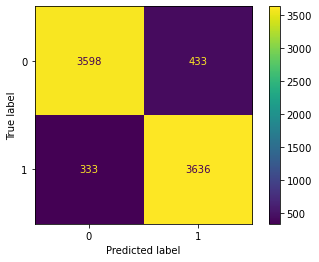

In [230]:
plot_confusion_matrix(final_pipeline,X_test,y_test)

In [233]:
y_hat=final_pipeline.predict(X_test)
classification_report(y_test,y_hat,output_dict=True)

{'0': {'precision': 0.9152887306029001,
  'recall': 0.8925824857355495,
  'f1-score': 0.9037930168299423,
  'support': 4031},
 '1': {'precision': 0.8935856475792578,
  'recall': 0.9160997732426304,
  'f1-score': 0.9047026623538195,
  'support': 3969},
 'accuracy': 0.90425,
 'macro avg': {'precision': 0.904437189091079,
  'recall': 0.90434112948909,
  'f1-score': 0.9042478395918809,
  'support': 8000},
 'weighted avg': {'precision': 0.9045212885377955,
  'recall': 0.90425,
  'f1-score': 0.9042443147154758,
  'support': 8000}}

# Feature Importance

We'll use the coefficients of each word/feature of the logistic regression model in order to evaluate which words have the most impact on positive or negative classification.

This requires us to match the vocabulary resulting from TFIDF Vectorization and chi-squared feature selection with coefficients of the model.  

The larger the absolute value of the coefficient, the more impact that feature has on classification.  Of note, it is important to remember that the feature is the TFIDF of the word, not just frequency count our an indication of its presence.  TFIDF gets larger as frequency of occurrence in a single text gets larger. It also increases as the number of documents in the corpus that contain the word decreases.

We'll use these coefficient values in lieu of frequencies to plot words according to their importance in a word cloud.

In [111]:
logreg_coef=final_pipeline.get_params()['model'].coef_[0]

In [112]:
len(logreg_coef)

12000

In [145]:
logreg_coef

array([ 1.26831499,  0.13798682,  0.35145426, ...,  0.18374362,
        0.64962357, -2.04667367])

In [117]:
#get dictionary of vocab and indices that were included in output

tfidf_mapping=final_pipeline.get_params()['vectorizer'].vocabulary_

In [119]:
tfidf_map=[(x,tfidf_mapping[x]) for x in tfidf_mapping]
tfidf_map[:10]

[('ok', 12364),
 ('nazi', 11908),
 ('befriends', 1495),
 ('first', 6427),
 ('get', 6984),
 ('major', 10404),
 ('star', 16647),
 ('idea', 8440),
 ('whatsoever', 19409),
 ('accent', 65)]

In [121]:
tfidf_map.sort(key=lambda x: x[1])

In [389]:
tfidf_map[:5]

[('aamir', 0), ('aaron', 1), ('ab', 2), ('abandon', 3), ('abandoned', 4)]

In [125]:
vocab_tfidf=[x[0] for x in tfidf_map]
vocab_tfidf[:10]

['aamir',
 'aaron',
 'ab',
 'abandon',
 'abandoned',
 'abbey',
 'abbott',
 'abbott costello',
 'abc',
 'abducted']

In [127]:
fitted_sel=final_pipeline.get_params()['selector']
fitted_sel

SelectPercentile(percentile=60, score_func=<function chi2 at 0x7f8864684c10>)

In [134]:
#get boolean mask of which features were selected by SelectPercentile
mask=fitted_sel.get_support()

In [135]:
mask

array([ True,  True,  True, ...,  True,  True, False])

In [138]:
final_vocab=np.array(vocab_tfidf)[mask]

In [139]:
len(final_vocab)

12000

In [148]:
coef_df=pd.DataFrame(list(zip(final_vocab,logreg_coef)),columns=['word','coef'])
coef_df.head()

,word,coef
0,aamir,1.268315
1,aaron,0.137987
2,ab,0.351454
3,abandoned,-0.703181
4,abc,0.098457


In [149]:
coef_df.sort_values(by='coef',ascending=False).head()

,word,coef
3361,excellent,8.688575
4508,great,8.640467
366,amazing,7.441927
7833,perfect,6.689702
10235,superb,6.680351


In [150]:
coef_df.sort_values(by='coef',ascending=False).tail()

,word,coef
10472,terrible,-8.607945
1207,boring,-9.441514
11453,waste,-10.282298
713,awful,-10.770877
11796,worst,-14.189735


In [428]:
coef_list=list(zip(final_vocab,logreg_coef))
coef_dict={x[0]: x[1] for x in coef_list}

Create word clouds to showcase the words with the largest positive and largest negative coefficients, since these are the words that contribute most to the logloss value corresponding to the probability that the review is either positive or negative.

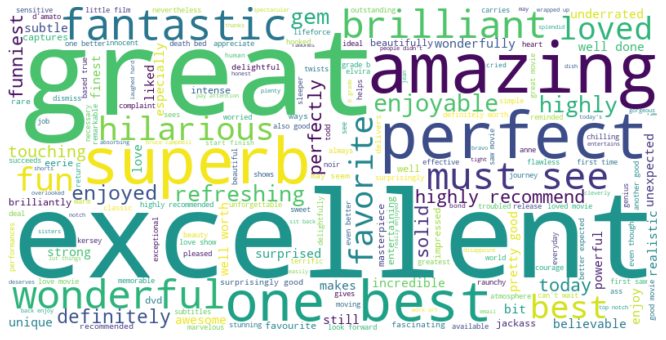

In [430]:
#plot word cloud for positive review classification
wordcloud=WordCloud(width=800,height=400,background_color='white')

wordcloud.generate_from_frequencies(coef_dict)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')
plt.show()
#wordcloud.to_file('pos_feature_importance.png')

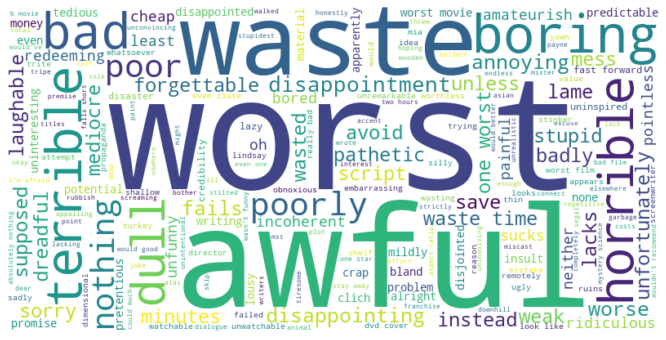

In [431]:
#plot word cloud for features contributing to negative review classification

coef_list=list(zip(final_vocab,logreg_coef*-1))
coef_dict={x[0]: x[1] for x in coef_list}

wordcloud=WordCloud(width=800,height=400,background_color='white')

wordcloud.generate_from_frequencies(coef_dict)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')
plt.show()
#wordcloud.to_file('neg_feature_importance.png')

The word clouds built from coefficient values look as we may expect them to.  'excellent' is the most important word to indicate positivity while 'worst' is the best indicator for negativity.

These word clouds don't provide a lot of insight into what causes the reviewer to like or dislike the movie (although some things can be gleaned from the smaller words)...they are more useful to see how a reviewer expresses either positive or negative feelings.

# Model Uses

## Get IMDB Data

In [ ]:
#Download all reviews available for the nine star wars episodes

In [167]:
#load key for IMDB API
def get_keys(path):
    with open(path) as f:
        return json.load(f)
    
keys = get_keys("/Users/morgandj/.secret/imdb-api_creds.json")
key=keys['key']

In [173]:
url='https://imdb-api.com/en/API/SearchMovie/'+key+'/Star Wars: Episode'
response=requests.get(url)

In [175]:
results=response.json()['results']

id_list=[]

for m in results:
    id_list.append((m['id'],m['title']))
    
id_list

[('tt0076759', 'Star Wars'),
 ('tt2527338', 'Star Wars: Episode IX - The Rise of Skywalker'),
 ('tt0120915', 'Star Wars: Episode I - The Phantom Menace'),
 ('tt0121766', 'Star Wars: Episode III - Revenge of the Sith'),
 ('tt2488496', 'Star Wars: Episode VII - The Force Awakens'),
 ('tt2527336', 'Star Wars: Episode VIII - The Last Jedi'),
 ('tt0121765', 'Star Wars: Episode II - Attack of the Clones'),
 ('tt0080684', 'Star Wars: Episode V - The Empire Strikes Back'),
 ('tt0086190', 'Star Wars: Episode VI - Return of the Jedi')]

In [200]:
review_url='https://imdb-api.com/en/API/Reviews/'+key+'/'
reviews=[]
response=requests.get(review_url+'tt0121765')
review_list=response.json()['items']
review_list

[{'username': 'TheLittleSongbird',
  'userUrl': 'https://www.imdb.com/user/ur20552756',
  'reviewLink': 'https://www.imdb.com/review/rw2150617',
  'warningSpoilers': False,
  'date': '1 November 2009',
  'rate': '6',
  'helpful': '15 out of 23 found this helpful.',
  'title': 'The weakest Star Wars movie, but not a total disaster',
  'content': "I do agree that this is the weakest of the six Star Wars movies, but it wasn't by all means a terrible movie. I will admit the dialogue is weak and gets nowhere at times, the plot isn't as well thought out and felt convoluted at best, Haydn Christensen does give a truly abysmal performance as Anakin and although the presence of Jar Jar Binks was toned down here his presence anywhere seemed jarring. Still despite the major flaws, it is a marvel to look at with stunning sets and impeccable CGI. The battle sequences are well choreographed, the pace is somewhat brisker than in Phantom Menace and the performances with the exception of Christensen ar

In [201]:
def get_reviews_by_id(imdb_id):
    #takes string imdb_id and returns list of reviews for that movie
    review_url='https://imdb-api.com/en/API/Reviews/'+key+'/'
    reviews=[]
    response=requests.get(review_url+imdb_id)
    review_list=response.json()['items']
    
    for review in review_list:
        reviews.append((review['rate'],review['content']))
    return reviews

In [202]:
reviews_dicts=[]

for (imdb_id,title) in id_list:

    review_list=get_reviews_by_id(imdb_id)
    for r in review_list:
        review_d={}
        review_d['id']=imdb_id
        review_d['title']=title
        review_d['rating']=r[0]
        review_d['review']=r[1]
        reviews_dicts.append(review_d)
        
reviews_df=pd.DataFrame(reviews_dicts)
reviews_df.head()

,id,title,rating,review
0,tt0076759,Star Wars,10,I couldn't have asked for anything more. Star ...
1,tt0076759,Star Wars,10,The awesome special effects and the creation o...
2,tt0076759,Star Wars,8,"Okay, so as a kid this was one of my favourite..."
3,tt0076759,Star Wars,,Star Wars (1977) **** (out of 4) Luke Skywalke...
4,tt0076759,Star Wars,10,This story happened 'A long time ago in a gala...


There are a number of missing rating numbers for the reviews. Convert these to np.nan so that the column can be converted to numeric values.

In [209]:
def fix_rating(r):
    if r == "":
        return np.nan
    else:
        return float(r)

In [211]:
reviews_df['rating']=reviews_df['rating'].apply(fix_rating)

In [212]:
reviews_df['rating'].describe()

count    186.000000
mean       7.387097
std        2.092624
min        2.000000
25%        6.000000
50%        7.500000
75%        9.000000
max       10.000000
Name: rating, dtype: float64

In [218]:
#Fix title of Episode IV
reviews_df['title']=reviews_df['title'].apply(lambda x: 'Star Wars: Episode IV' if x == 'Star Wars' else x)

In [219]:
reviews_df.to_csv('starwars_reviews.csv')

In [220]:
reviews_df.head()

,id,title,rating,review
0,tt0076759,Star Wars: Episode IV,10.0,I couldn't have asked for anything more. Star ...
1,tt0076759,Star Wars: Episode IV,10.0,The awesome special effects and the creation o...
2,tt0076759,Star Wars: Episode IV,8.0,"Okay, so as a kid this was one of my favourite..."
3,tt0076759,Star Wars: Episode IV,NaN,Star Wars (1977) **** (out of 4) Luke Skywalke...
4,tt0076759,Star Wars: Episode IV,10.0,This story happened 'A long time ago in a gala...


## Classify Reviews

In [234]:
SW_X=reviews_df['review']

SW_predictions=final_pipeline.predict(SW_X)

reviews_df['prediction']=SW_predictions

reviews_df.head()

,id,title,rating,review,prediction
0,tt0076759,Star Wars: Episode IV,10.0,I couldn't have asked for anything more. Star ...,1
1,tt0076759,Star Wars: Episode IV,10.0,The awesome special effects and the creation o...,1
2,tt0076759,Star Wars: Episode IV,8.0,"Okay, so as a kid this was one of my favourite...",1
3,tt0076759,Star Wars: Episode IV,NaN,Star Wars (1977) **** (out of 4) Luke Skywalke...,1
4,tt0076759,Star Wars: Episode IV,10.0,This story happened 'A long time ago in a gala...,1


## Analyze Results

In [236]:
pos_reviews=reviews_df[reviews_df['prediction']==1]
neg_reviews=reviews_df[reviews_df['prediction']==0]

In [237]:
avg_pos_rate=pos_reviews['rating'].mean()
avg_neg_rate=neg_reviews['rating'].mean()
print('Average Rating Scores:')
print('Positive reviews: {}'.format(avg_pos_rate))
print('Negative reveiws: {}'.format(avg_neg_rate))

Average Rating Scores:
Positive reviews: 8.023622047244094
Negative reveiws: 6.016949152542373


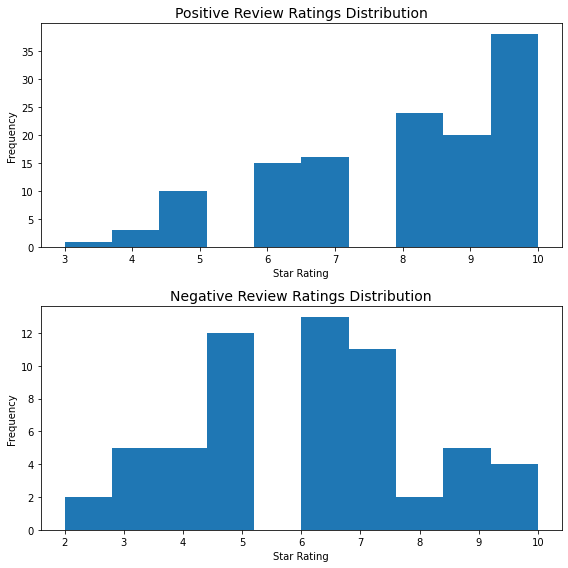

In [404]:
fig,axes=plt.subplots(2,figsize=(8,8))

pos_reviews['rating'].plot.hist(ax=axes[0])
axes[0].set_title('Positive Review Ratings Distribution',fontsize=14)
axes[0].set_xlabel('Star Rating')

neg_reviews['rating'].plot.hist(ax=axes[1])
axes[1].set_title('Negative Review Ratings Distribution',fontsize=14)
axes[1].set_xlabel('Star Rating')
plt.tight_layout()

Our predictions show that negative reviews tend to be centered on a rating around 6 while positive reviews are left skewed, with an average around 8. This could be due to inflation of star ratings or to inaccuracy of the review labels.

We'll use wordcloud to look at the most important words in the positive and negative reviews.  

In [261]:
#adjust stopwords list to keep certain words from dominating word cloud
sw_stop=stopwords_list
words_to_add=['star','wars','movie','film','character','one','characters',
             'movies','films','also']
sw_stop.extend(words_to_add)

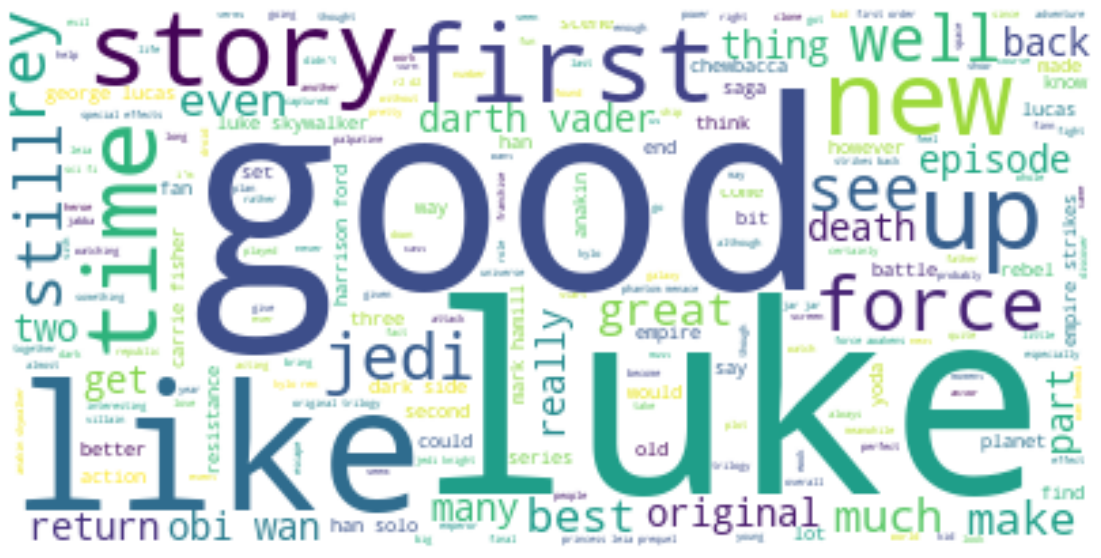

In [384]:
#plot wordcloud based on frequency of words in positive reviews
pos_text = pos_reviews['review'].to_list()
all_pos = ' '.join(pos_text).lower()

wordcloud = WordCloud(stopwords=sw_stop,
                     collocations=True,
                     background_color='white').generate(all_pos)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud.to_file('pos_reviews.png')

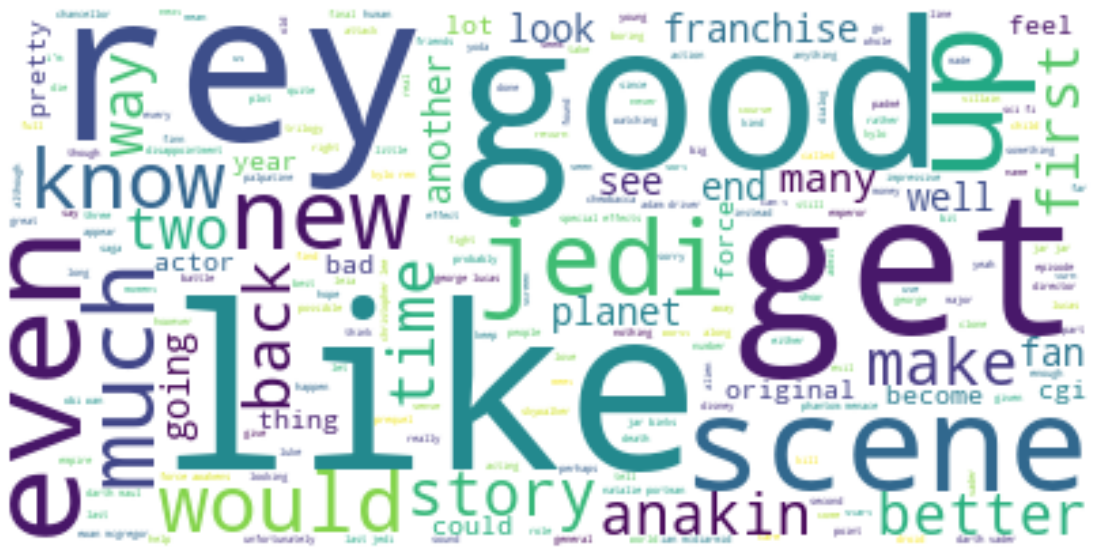

In [396]:
#plot word cloud based on frequency of words in negative reviews
neg_text = neg_reviews['review'].to_list()
all_neg = ' '.join(neg_text).lower()

wordcloud = WordCloud(stopwords=sw_stop,
                     collocations=True,
                     background_color='white').generate(all_neg)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud.to_file('neg_reviews.png')

### Scrape List of Star Wars Characters

Examine character names in the positive reviews to determine which characters are written about more often in positive vs. negative reviews. This can provide insight into liked/disliked or controversial characters.  It is not perfect since a character can be mentioned in a positive way in a negative review or vice versa, but it can provide a rough analysis.

In [285]:
char_url='https://en.wikipedia.org/wiki/List_of_Star_Wars_characters'
response=requests.get(char_url)
soup=BeautifulSoup(response.content,'html.parser')

In [298]:
tables=soup.findAll('tbody')
char_tables=[]

for t in tables:
    if t.find('th')!=None:
        if t.find('th').text=='Name\n':
            char_tables.append(t)


In [324]:
names_list=[]

for table in char_tables:
    rows=table.find_all('tr')
    for row in rows:
        if row.find('a') != None:
            name=row.find('a').get('title')
            names_list.append(name)


In [325]:
names_list=[x for x in names_list if x != None]

In [327]:
names=[]

for n in names_list:
    names.extend(n.split())

In [368]:
words_to_remove=['Star','Wars:','(actor)','characters','(Star','Wars)',
                 'List','(dialect','coach)','character','actor)',
                 'Wikipedia:Citation','needed','TV','(2003','(2015','(EP)',
                 '(TV','(English','(sound','a','the','of','saw','one','story',
                 'not','down','special','wars','does']
words_to_remove=[w.lower() for w in words_to_remove]
names=[n.lower() for n in names]
names_=set([n for n in names if n not in words_to_remove])


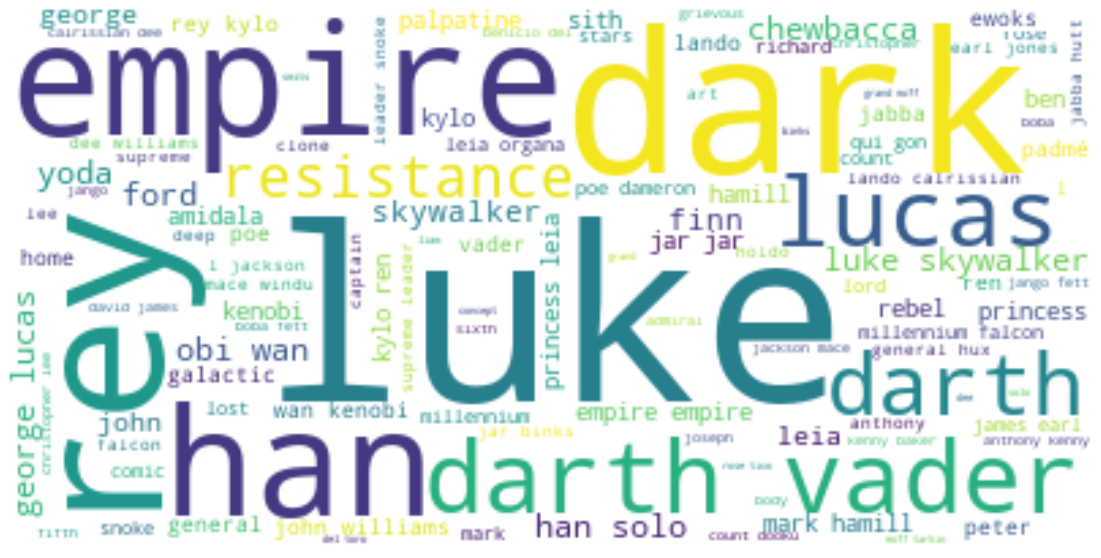

In [383]:
#filter pos/neg review texts for character name mentions

pos_chars=" ".join([w for w in all_pos.split() if w in names_])

wordcloud = WordCloud(stopwords=sw_stop,
                     collocations=True,
                     background_color='white').generate(pos_chars)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud.to_file('pos_chars.png')

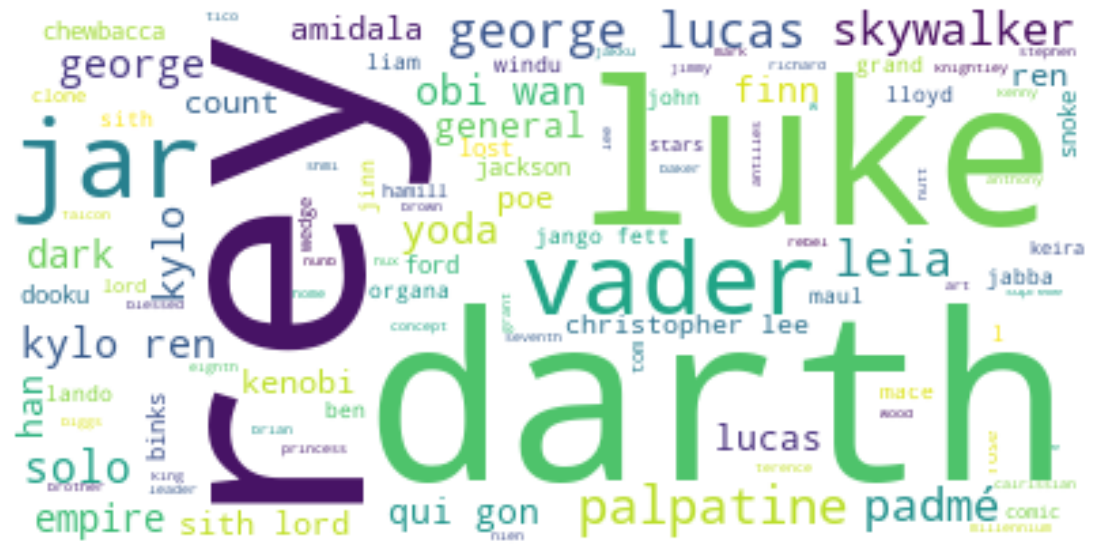

In [382]:
neg_chars=" ".join([w for w in all_neg.split() if w in names_])

wordcloud = WordCloud(stopwords=sw_stop,
                     collocations=True,
                     background_color='white').generate(neg_chars)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud.to_file('neg_chars.png')

# Conclusions #

We built a binary text classification model using TFIDF Vectorization, Chi squared feature selection, and Logistic Regression that classifies IMDB movie reviews as positive or negative with 90% accuracy.

Word Clouds were plotted to show which words are the most important to the model for indicating that the review is positive or negative.

Lastly, we downloaded new movie reviews to classify with our final model. The results were used to evaluate whether our model aligns with the IMDB star ratings (negative reviews still had a relatively high average of 6) and to see which words/characters were mentioned most often in both the positive and negative reviews.  This could be done with a certain genre as well to evaluate what has made movies successful when writing a business or marketing plan.

## Next Steps ##

* Use transfer learning to apply more sophisticated models to the problem
* Obtain labels for multiclassification to refine the sentiment classification (add neutral label)
* Apply more sophisticated sentiment analysis that can determine more specifically what was positive or negative about the review (aspect-based sentiment analysis)